In [16]:
import probdiffeq.taylor as taylor
import jax
import jax.numpy as jnp

tcoeffs = taylor.odejet_padded_scan(
    lambda y, dy: -y, (jnp.asarray([1, 0]), jnp.asarray([2, 0])), num=1
)
jnp.array(tcoeffs)

Array([[ 1,  0],
       [ 2,  0],
       [-1,  0]], dtype=int32)

taylor [ 1  0 -1  0  1  0 -1  0  1]
timesteps: 10
delta: 0.6666666666666666
(10, 9)
0.9601682579080809 0.5818038921905259


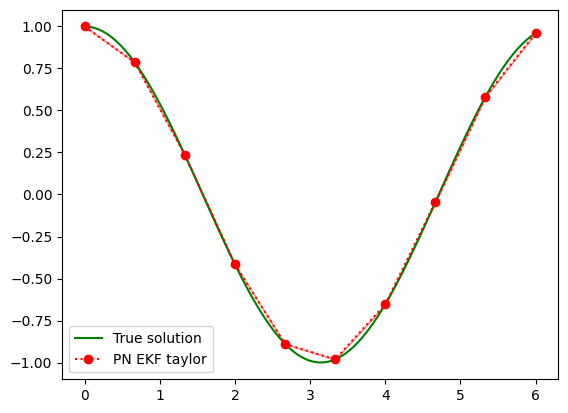

In [27]:
from probabilistic_numerics import kalman_filter as pn
import matplotlib.pyplot as plt

end_time = 6


def pn_solve_nonlinear_IVP(q, ax, n_solution_points, taylor_init, prior_matrix):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1.0)
    initial_mean = initial_mean.at[2].set(-1.0)
    if taylor_init == "taylor":
        tcoeffs = taylor.odejet_padded_scan(lambda y, dy: -y, (1, 0), num=q - 1)
        initial_mean = jnp.array(tcoeffs)

    print(taylor_init, initial_mean)

    print("timesteps:", n_solution_points)
    delta = end_time / (n_solution_points - 1)
    print("delta:", delta)

    def zero_obs(state, time, step):
        return jnp.array([state[0] + state[2]])

    _samples, means, stds = pn.solve_nonlinear_IVP(
        prior_matrix=prior_matrix,
        initial_mean=initial_mean,
        initial_cov_diag=jnp.array([0, 0, 0] + [1] * (q - 2))
        if taylor_init == "no taylor"
        else jnp.array([0] * (q + 1)),
        derivatives=q,
        n_solution_points=n_solution_points,
        delta_time=delta,
        prior="iwp",
        observation_function=zero_obs,
        update_indicator=jnp.array([False] + [True] * (n_solution_points - 1)),
        observation_uncertainty=jnp.eye(1) * 0,
    )
    print(means.shape)
    print(means[-1, 0], means[-2, 0])
    # means = means[:, 0]
    # stds = stds[:, 0]

    x_axis = jnp.linspace(0, end_time, n_solution_points, endpoint=True)
    means = jnp.interp(
        x_axis, jnp.linspace(0, end_time, n_solution_points, endpoint=True), means[:, 0]
    )
    stds = jnp.interp(
        x_axis, jnp.linspace(0, end_time, n_solution_points, endpoint=True), stds[:, 0]
    )
    ax.plot(
        x_axis,
        means,
        label="PN EKF " + taylor_init,
        linestyle="dotted",
        color="r" if taylor_init == "taylor" else "b",
        marker="o",
    )
    ax.fill_between(
        x_axis,
        means - stds * 3,
        means + stds * 3,
        alpha=0.4,
        color="r" if taylor_init == "taylor" else "b",
    )


plt.gca().plot(
    jnp.linspace(0, end_time, 100, endpoint=False),
    jnp.cos(jnp.linspace(0, end_time, 100, endpoint=False)),
    label="True solution",
    color="g",
)
# pn_solve_nonlinear_IVP(5, plt.gca(), timesteps=20, prior_name="iwp", prior_matrix=[-1])
# pn_solve_nonlinear_IVP(
#     8, plt.gca(), timesteps=20, taylor_init="taylor", prior_matrix=[-1]
# )
pn_solve_nonlinear_IVP(
    8, plt.gca(), n_solution_points=10, taylor_init="taylor", prior_matrix=[-1]
)
plt.gca().legend()